
### 1. Einleitung und Laden der Python-Pakete

Die folgenden Python-Pakete stammen u.a. aus dem TU-Kurs "Data Science" und den Python-Modulen "TextBlob" und "NLTK" (Natural Language Toolkit) und weiteren obligatorischen Paketen und Modulen von Python, welche die Analyse und Darstellung der Twitter Daten und der Ergebnisse unterstützen.

Um die vollständigen Tabellen zu sichten, kann der Befehl tbl.show() verwendet werden bspw. in Zeile 2: "clinton_table.show()" anstelle von "clinton_table". Da es sich bei allen behandelten Twitter-Accounts um große Datenmengen von mehreren tausend Tweets handelt, wurde für die Veranschaulichung der Skripte im .pdf-Format auf eine vollständige Darstellung aller Tabellen verzichtet, um eine angemessene Seitenzahl zu bewahren. Stattdessen werden bei großen Tabellen, welche die gesamte Tweetanzahl beinhalten, jeweils die ersten zehn Einträge abgebildet.

Einzelne Arbeitsschritte werden innerhalb der Zeilen mittels der Python-Kommentarfunktion "#" beschrieben.

In [1]:
from datascience import *
import numpy as np
import pandas as pd
import math
import scipy
import statistics
import tweepy as tw
import io 
import tables
import regex as re
import os
import networkx
import warnings
warnings.filterwarnings("ignore")
import spacy
from bs4 import BeautifulSoup
import collections
import itertools
from lexical_diversity import lex_div as ld

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

import textblob as TextBlob
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.taggers import NLTKTagger

### 2. Datenaufbereitung

In [2]:
# Laden der vom Skript gecrawlten .csv Tabelle.
clinton_table = Table.read_table("C:/Users/cati_/Desktop/Sentiment_Data_Try/ALL_Clinton_Tweets.csv", names=['User', 'Tweet_Nr', 'Date_Time', 'Text'])
clinton_table
#clinton_table.show()

User,Tweet_Nr,Date_Time,Text
HillaryClinton,1230904643393335298,2020-02-21 17:18:30,b'Putin's Puppet is at it again taking Russian help for ...
HillaryClinton,1230553203181281280,2020-02-20 18:02:00,b'Advancing the rights of women and girls is the great u ...
HillaryClinton,1230252277019090944,2020-02-19 22:06:14,b'Small islands contribute the least to climate change b ...
HillaryClinton,1229913993155883016,2020-02-18 23:42:01,b'Such a terrific day visiting ClintonFdn partners in P ...
HillaryClinton,1228364820702990336,2020-02-14 17:06:09,b'In the last 24 hours the American president has: 1. Co ...
HillaryClinton,1228355797513576448,2020-02-14 16:30:18,b'Today commit to VoteforJaimeGuttenberg and an end to ...
HillaryClinton,1228355569272139776,2020-02-14 16:29:24,b'Today we remember Parkland and the 17 people whose li ...
HillaryClinton,1228033652459810826,2020-02-13 19:10:13,b'For 100 years LWV has empowered voters and defended d ...
HillaryClinton,1227624147666292741,2020-02-12 16:02:59,b'Trump is using the powers of the presidency like a tyr ...
HillaryClinton,1227423160590577664,2020-02-12 02:44:20,b'Do you realize intimidating judges is the behavior of ...


In [3]:
# Auswahl der relevanten Spalten für die Datenbereinigung.
clinton_first = clinton_table.select("Text", "Date_Time", "Tweet_Nr")
clinton_first

Text,Date_Time,Tweet_Nr
b'Putin's Puppet is at it again taking Russian help for ...,2020-02-21 17:18:30,1230904643393335298
b'Advancing the rights of women and girls is the great u ...,2020-02-20 18:02:00,1230553203181281280
b'Small islands contribute the least to climate change b ...,2020-02-19 22:06:14,1230252277019090944
b'Such a terrific day visiting ClintonFdn partners in P ...,2020-02-18 23:42:01,1229913993155883016
b'In the last 24 hours the American president has: 1. Co ...,2020-02-14 17:06:09,1228364820702990336
b'Today commit to VoteforJaimeGuttenberg and an end to ...,2020-02-14 16:30:18,1228355797513576448
b'Today we remember Parkland and the 17 people whose li ...,2020-02-14 16:29:24,1228355569272139776
b'For 100 years LWV has empowered voters and defended d ...,2020-02-13 19:10:13,1228033652459810826
b'Trump is using the powers of the presidency like a tyr ...,2020-02-12 16:02:59,1227624147666292741
b'Do you realize intimidating judges is the behavior of ...,2020-02-12 02:44:20,1227423160590577664


In [4]:
# Entfernung der byte-Kennzeichnung b' und b" zu Beginn der Tweets. 
clinton_without_b = [tweet.strip("b") for tweet in clinton_first.column("Text")]

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_second = clinton_first.with_column("Without Byte", clinton_without_b)
clinton_second

Text,Date_Time,Tweet_Nr,Without Byte
b'Putin's Puppet is at it again taking Russian help for ...,2020-02-21 17:18:30,1230904643393335298,'Putin's Puppet is at it again taking Russian help for h ...
b'Advancing the rights of women and girls is the great u ...,2020-02-20 18:02:00,1230553203181281280,'Advancing the rights of women and girls is the great un ...
b'Small islands contribute the least to climate change b ...,2020-02-19 22:06:14,1230252277019090944,'Small islands contribute the least to climate change bu ...
b'Such a terrific day visiting ClintonFdn partners in P ...,2020-02-18 23:42:01,1229913993155883016,'Such a terrific day visiting ClintonFdn partners in Pu ...
b'In the last 24 hours the American president has: 1. Co ...,2020-02-14 17:06:09,1228364820702990336,'In the last 24 hours the American president has: 1. Cor ...
b'Today commit to VoteforJaimeGuttenberg and an end to ...,2020-02-14 16:30:18,1228355797513576448,'Today commit to VoteforJaimeGuttenberg and an end to g ...
b'Today we remember Parkland and the 17 people whose li ...,2020-02-14 16:29:24,1228355569272139776,'Today we remember Parkland and the 17 people whose liv ...
b'For 100 years LWV has empowered voters and defended d ...,2020-02-13 19:10:13,1228033652459810826,'For 100 years LWV has empowered voters and defended de ...
b'Trump is using the powers of the presidency like a tyr ...,2020-02-12 16:02:59,1227624147666292741,'Trump is using the powers of the presidency like a tyra ...
b'Do you realize intimidating judges is the behavior of ...,2020-02-12 02:44:20,1227423160590577664,'Do you realize intimidating judges is the behavior of f ...


In [5]:
# Erweiterte Legende zur Übersetzung der Kontraktionen.
CONTRACTION_MAP = {
"ain't": "is not",
"amn't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"'cuz": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"daren't": "dare not",
"daresn't": "dare not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"e'er": "ever",
"everyone's": "everyone is",
"finna": "going to",
"gimme": "give me",
"giv'n": "given",
"gonna": "going to",
"gon't": "go not",
"gotta": "got to",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"he've": "he have",
"how'd": "how did",
"how'd'y": "how do you",
"howdy": "how do you do",
"how'll": "how will",
"how're": "how are",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i'm'a": "i am about to",
"i'm'o": "i am going to",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"may've": "may have",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"ne'er": "never",
"o'clock": "of the clock",
"o'er": "over",
"ol'": "old",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shalln't": "shall not",
"shan't": "shall not",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"somebody's": "somebody has",
"someone's": "someone has",
"something's": "something has",
"so're": "so are",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that'll": "that shall",
"that'r": "that are",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there'll": "there will",
"there're": "there are",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"this's": "this is",
"those're": "those are",
"'tis": "it is",
"to've": "to have",
"'twas": "it was",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'd": "what did",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where're": "where are",
"where's": "where is",
"where've": "where have",
"which's": "which has",
"who'd": "who would",
"who'd've": "who would have",
"who'll": "who will",
"who'll've": "who will have",
"who're": "who are",
"who's": "who is",
"who've": "who have",
"why'd": "why did",
"why're": "why are",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [6]:
# Funktion zur Übersetzung der Kontraktionen mittels der erstellten Legende.
def expand_contractions(txt, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, txt)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
clinton_contractions = clinton_second.apply(expand_contractions, "Without Byte") 

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_third = clinton_second.with_column("Without Contractions", clinton_contractions)
clinton_third

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions
b'Putin's Puppet is at it again taking Russian help for ...,2020-02-21 17:18:30,1230904643393335298,'Putin's Puppet is at it again taking Russian help for h ...,Putins Puppet is at it again taking Russian help for him ...
b'Advancing the rights of women and girls is the great u ...,2020-02-20 18:02:00,1230553203181281280,'Advancing the rights of women and girls is the great un ...,Advancing the rights of women and girls is the great unf ...
b'Small islands contribute the least to climate change b ...,2020-02-19 22:06:14,1230252277019090944,'Small islands contribute the least to climate change bu ...,Small islands contribute the least to climate change but ...
b'Such a terrific day visiting ClintonFdn partners in P ...,2020-02-18 23:42:01,1229913993155883016,'Such a terrific day visiting ClintonFdn partners in Pu ...,Such a terrific day visiting ClintonFdn partners in Pue ...
b'In the last 24 hours the American president has: 1. Co ...,2020-02-14 17:06:09,1228364820702990336,'In the last 24 hours the American president has: 1. Cor ...,In the last 24 hours the American president has: 1. Corr ...
b'Today commit to VoteforJaimeGuttenberg and an end to ...,2020-02-14 16:30:18,1228355797513576448,'Today commit to VoteforJaimeGuttenberg and an end to g ...,Today commit to VoteforJaimeGuttenberg and an end to gu ...
b'Today we remember Parkland and the 17 people whose li ...,2020-02-14 16:29:24,1228355569272139776,'Today we remember Parkland and the 17 people whose liv ...,Today we remember Parkland and the 17 people whose live ...
b'For 100 years LWV has empowered voters and defended d ...,2020-02-13 19:10:13,1228033652459810826,'For 100 years LWV has empowered voters and defended de ...,For 100 years LWV has empowered voters and defended dem ...
b'Trump is using the powers of the presidency like a tyr ...,2020-02-12 16:02:59,1227624147666292741,'Trump is using the powers of the presidency like a tyra ...,Trump is using the powers of the presidency like a tyran ...
b'Do you realize intimidating judges is the behavior of ...,2020-02-12 02:44:20,1227423160590577664,'Do you realize intimidating judges is the behavior of f ...,Do you realize intimidating judges is the behavior of fa ...


In [7]:
# Funktion zur Entfernung der URLs und der Interpunktion innerhalb der Tweets.
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
clinton_URLs = clinton_third.apply(remove_url, "Without Contractions")

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_fourth = clinton_third.with_column("Without URLs", clinton_URLs)
clinton_fourth

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions,Without URLs
b'Putin's Puppet is at it again taking Russian help for ...,2020-02-21 17:18:30,1230904643393335298,'Putin's Puppet is at it again taking Russian help for h ...,Putins Puppet is at it again taking Russian help for him ...,Putins Puppet is at it again taking Russian help for him ...
b'Advancing the rights of women and girls is the great u ...,2020-02-20 18:02:00,1230553203181281280,'Advancing the rights of women and girls is the great un ...,Advancing the rights of women and girls is the great unf ...,Advancing the rights of women and girls is the great unf ...
b'Small islands contribute the least to climate change b ...,2020-02-19 22:06:14,1230252277019090944,'Small islands contribute the least to climate change bu ...,Small islands contribute the least to climate change but ...,Small islands contribute the least to climate change but ...
b'Such a terrific day visiting ClintonFdn partners in P ...,2020-02-18 23:42:01,1229913993155883016,'Such a terrific day visiting ClintonFdn partners in Pu ...,Such a terrific day visiting ClintonFdn partners in Pue ...,Such a terrific day visiting ClintonFdn partners in Puer ...
b'In the last 24 hours the American president has: 1. Co ...,2020-02-14 17:06:09,1228364820702990336,'In the last 24 hours the American president has: 1. Cor ...,In the last 24 hours the American president has: 1. Corr ...,In the last 24 hours the American president has 1 Corrup ...
b'Today commit to VoteforJaimeGuttenberg and an end to ...,2020-02-14 16:30:18,1228355797513576448,'Today commit to VoteforJaimeGuttenberg and an end to g ...,Today commit to VoteforJaimeGuttenberg and an end to gu ...,Today commit to VoteforJaimeGuttenberg and an end to gun ...
b'Today we remember Parkland and the 17 people whose li ...,2020-02-14 16:29:24,1228355569272139776,'Today we remember Parkland and the 17 people whose liv ...,Today we remember Parkland and the 17 people whose live ...,Today we remember Parkland and the 17 people whose lives ...
b'For 100 years LWV has empowered voters and defended d ...,2020-02-13 19:10:13,1228033652459810826,'For 100 years LWV has empowered voters and defended de ...,For 100 years LWV has empowered voters and defended dem ...,For 100 years LWV has empowered voters and defended demo ...
b'Trump is using the powers of the presidency like a tyr ...,2020-02-12 16:02:59,1227624147666292741,'Trump is using the powers of the presidency like a tyra ...,Trump is using the powers of the presidency like a tyran ...,Trump is using the powers of the presidency like a tyran ...
b'Do you realize intimidating judges is the behavior of ...,2020-02-12 02:44:20,1227423160590577664,'Do you realize intimidating judges is the behavior of f ...,Do you realize intimidating judges is the behavior of fa ...,Do you realize intimidating judges is the behavior of fa ...


In [8]:
# Funktion zur Ausgabe der großgeschriebenen Wörter bzw. der Majuskelschreibung.
def show_upper(txt):
    upper_pattern = re.compile('([A-Z][A-Z]+)')
    return re.findall(upper_pattern, txt)

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
clinton_upper = clinton_fourth.apply(show_upper, "Without URLs")

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_fifth = clinton_fourth.with_column("Upper Text", clinton_upper)
clinton_fifth

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions,Without URLs,Upper Text
b'Putin's Puppet is at it again taking Russian help for ...,2020-02-21 17:18:30,1230904643393335298,'Putin's Puppet is at it again taking Russian help for h ...,Putins Puppet is at it again taking Russian help for him ...,Putins Puppet is at it again taking Russian help for him ...,[]
b'Advancing the rights of women and girls is the great u ...,2020-02-20 18:02:00,1230553203181281280,'Advancing the rights of women and girls is the great un ...,Advancing the rights of women and girls is the great unf ...,Advancing the rights of women and girls is the great unf ...,['DVF']
b'Small islands contribute the least to climate change b ...,2020-02-19 22:06:14,1230252277019090944,'Small islands contribute the least to climate change bu ...,Small islands contribute the least to climate change but ...,Small islands contribute the least to climate change but ...,['CGI']
b'Such a terrific day visiting ClintonFdn partners in P ...,2020-02-18 23:42:01,1229913993155883016,'Such a terrific day visiting ClintonFdn partners in Pu ...,Such a terrific day visiting ClintonFdn partners in Pue ...,Such a terrific day visiting ClintonFdn partners in Puer ...,[]
b'In the last 24 hours the American president has: 1. Co ...,2020-02-14 17:06:09,1228364820702990336,'In the last 24 hours the American president has: 1. Cor ...,In the last 24 hours the American president has: 1. Corr ...,In the last 24 hours the American president has 1 Corrup ...,[]
b'Today commit to VoteforJaimeGuttenberg and an end to ...,2020-02-14 16:30:18,1228355797513576448,'Today commit to VoteforJaimeGuttenberg and an end to g ...,Today commit to VoteforJaimeGuttenberg and an end to gu ...,Today commit to VoteforJaimeGuttenberg and an end to gun ...,[]
b'Today we remember Parkland and the 17 people whose li ...,2020-02-14 16:29:24,1228355569272139776,'Today we remember Parkland and the 17 people whose liv ...,Today we remember Parkland and the 17 people whose live ...,Today we remember Parkland and the 17 people whose lives ...,['AM']
b'For 100 years LWV has empowered voters and defended d ...,2020-02-13 19:10:13,1228033652459810826,'For 100 years LWV has empowered voters and defended de ...,For 100 years LWV has empowered voters and defended dem ...,For 100 years LWV has empowered voters and defended demo ...,['LWV']
b'Trump is using the powers of the presidency like a tyr ...,2020-02-12 16:02:59,1227624147666292741,'Trump is using the powers of the presidency like a tyra ...,Trump is using the powers of the presidency like a tyran ...,Trump is using the powers of the presidency like a tyran ...,[]
b'Do you realize intimidating judges is the behavior of ...,2020-02-12 02:44:20,1227423160590577664,'Do you realize intimidating judges is the behavior of f ...,Do you realize intimidating judges is the behavior of fa ...,Do you realize intimidating judges is the behavior of fa ...,[]


In [9]:
# Auswahl der Spalte der bereinigten Tweets inkl. Majuskelschreibung.
clinton_tweets_capitalized = clinton_fifth.select("Without URLs", "Upper Text")

# Exportieren der Tabelle als .csv-Datei.
clinton_tweets_capitalized.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_tweets_capitalized.csv")

In [10]:
# Anwendung der Python-Funktion ".lower()" auf die bereinigte Spalte bzw. den Text zur konsequenten Minuskelschreibung.
clinton_decapitalized = [tweet.lower() for tweet in clinton_fifth.column("Without URLs")]

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_sixth = clinton_fifth.with_column("Decapitalized", clinton_decapitalized)
clinton_sixth

Text,Date_Time,Tweet_Nr,Without Byte,Without Contractions,Without URLs,Upper Text,Decapitalized
b'Putin's Puppet is at it again taking Russian help for ...,2020-02-21 17:18:30,1230904643393335298,'Putin's Puppet is at it again taking Russian help for h ...,Putins Puppet is at it again taking Russian help for him ...,Putins Puppet is at it again taking Russian help for him ...,[],putins puppet is at it again taking russian help for him ...
b'Advancing the rights of women and girls is the great u ...,2020-02-20 18:02:00,1230553203181281280,'Advancing the rights of women and girls is the great un ...,Advancing the rights of women and girls is the great unf ...,Advancing the rights of women and girls is the great unf ...,['DVF'],advancing the rights of women and girls is the great unf ...
b'Small islands contribute the least to climate change b ...,2020-02-19 22:06:14,1230252277019090944,'Small islands contribute the least to climate change bu ...,Small islands contribute the least to climate change but ...,Small islands contribute the least to climate change but ...,['CGI'],small islands contribute the least to climate change but ...
b'Such a terrific day visiting ClintonFdn partners in P ...,2020-02-18 23:42:01,1229913993155883016,'Such a terrific day visiting ClintonFdn partners in Pu ...,Such a terrific day visiting ClintonFdn partners in Pue ...,Such a terrific day visiting ClintonFdn partners in Puer ...,[],such a terrific day visiting clintonfdn partners in puer ...
b'In the last 24 hours the American president has: 1. Co ...,2020-02-14 17:06:09,1228364820702990336,'In the last 24 hours the American president has: 1. Cor ...,In the last 24 hours the American president has: 1. Corr ...,In the last 24 hours the American president has 1 Corrup ...,[],in the last 24 hours the american president has 1 corrup ...
b'Today commit to VoteforJaimeGuttenberg and an end to ...,2020-02-14 16:30:18,1228355797513576448,'Today commit to VoteforJaimeGuttenberg and an end to g ...,Today commit to VoteforJaimeGuttenberg and an end to gu ...,Today commit to VoteforJaimeGuttenberg and an end to gun ...,[],today commit to voteforjaimeguttenberg and an end to gun ...
b'Today we remember Parkland and the 17 people whose li ...,2020-02-14 16:29:24,1228355569272139776,'Today we remember Parkland and the 17 people whose liv ...,Today we remember Parkland and the 17 people whose live ...,Today we remember Parkland and the 17 people whose lives ...,['AM'],today we remember parkland and the 17 people whose lives ...
b'For 100 years LWV has empowered voters and defended d ...,2020-02-13 19:10:13,1228033652459810826,'For 100 years LWV has empowered voters and defended de ...,For 100 years LWV has empowered voters and defended dem ...,For 100 years LWV has empowered voters and defended demo ...,['LWV'],for 100 years lwv has empowered voters and defended demo ...
b'Trump is using the powers of the presidency like a tyr ...,2020-02-12 16:02:59,1227624147666292741,'Trump is using the powers of the presidency like a tyra ...,Trump is using the powers of the presidency like a tyran ...,Trump is using the powers of the presidency like a tyran ...,[],trump is using the powers of the presidency like a tyran ...
b'Do you realize intimidating judges is the behavior of ...,2020-02-12 02:44:20,1227423160590577664,'Do you realize intimidating judges is the behavior of f ...,Do you realize intimidating judges is the behavior of fa ...,Do you realize intimidating judges is the behavior of fa ...,[],do you realize intimidating judges is the behavior of fa ...


In [11]:
# Auswahl der final bereinigten Spalte für die anschließende externe POS-Analyse.
clinton_final_cleaned_tweets = clinton_sixth.select("Decapitalized")

# Exportieren der Tabelle als .csv-Datei.
clinton_final_cleaned_tweets.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_final_cleaned_tweets.csv")

### 3. Sentiment-Analyse der Tweets

In [12]:
# Funktion zur Ermittlung der Sentiment-Werte der Tweets.
sentiment_objects = [TextBlob(text) for text in clinton_decapitalized]
sentiment_objects[0].polarity, sentiment_objects[0]

sentiment_values = [[text.sentiment.polarity, str(text)] for text in sentiment_objects]
sentiment_values[0]

sentiment_df = pd.DataFrame(sentiment_values, columns=["Sentiment", "Decapitalized"])
sentiment_df.head()

,Sentiment,Decapitalized
0,0.400000,putins puppet is at it again taking russian he...
1,0.500000,advancing the rights of women and girls is the...
2,-0.245833,small islands contribute the least to climate ...
3,0.114286,such a terrific day visiting clintonfdn partne...
4,-0.040000,in the last 24 hours the american president ha...


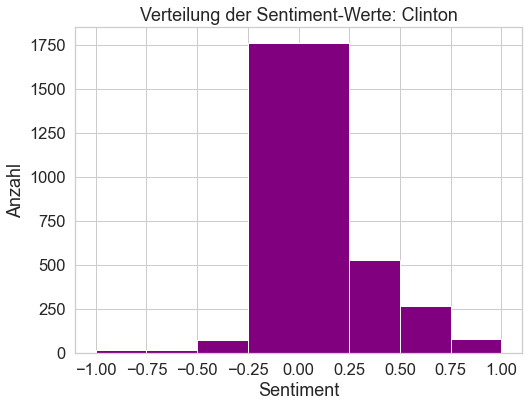

In [13]:
# Visualisierung des Histogramms der Sentiment-Analyse der Tweets.
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax, color="purple")
plt.title("Verteilung der Sentiment-Werte: Clinton")
plt.xlabel('Sentiment')
plt.ylabel('Anzahl')
plt.savefig("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_sentiment_tweets.png")
plt.show()

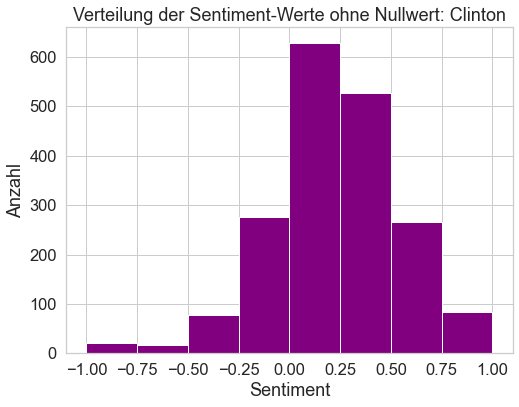

In [14]:
# Visualisierung der Sentiment-Analyse ohne den Nullwert, um die Verteilung der Tweets auf die negativen und positiven Pole differenzierter darstellen zukönnen.

# Entfernung der neutralen Sentiment-Werte bzw. der Nullwerte.
sentiment_zero_df = sentiment_df[sentiment_df.Sentiment != 0]

# Visualisierung des Histogramms der Sentiment-Analyse der Tweets ohne Nullwert.
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_zero_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1], ax=ax, color="purple")
plt.title("Verteilung der Sentiment-Werte ohne Nullwert: Clinton")
plt.xlabel('Sentiment')
plt.ylabel('Anzahl')
plt.savefig("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_sentiment_tweets_ohne_null.png")
plt.show()

In [15]:
# Exportieren der Werte der Sentiment-Analyse als .csv-Datei.
sentiment_df.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_sentiment.csv")

In [16]:
# Funktion zur Ermittlung der Subjektivitätswerte der Tweets.
subjectivity_objects = [TextBlob(text) for text in clinton_decapitalized]
subjectivity_objects[0].subjectivity, subjectivity_objects[0]

subjectivity_values = [[text.sentiment.subjectivity, str(text)] for text in subjectivity_objects]
subjectivity_values[0]

subjectivity_df = pd.DataFrame(subjectivity_values, columns=["Subjectivity", "Decapitalized"])
subjectivity_df.head()

,Subjectivity,Decapitalized
0,0.200000,putins puppet is at it again taking russian he...
1,0.487500,advancing the rights of women and girls is the...
2,0.508333,small islands contribute the least to climate ...
3,0.371429,such a terrific day visiting clintonfdn partne...
4,0.313333,in the last 24 hours the american president ha...


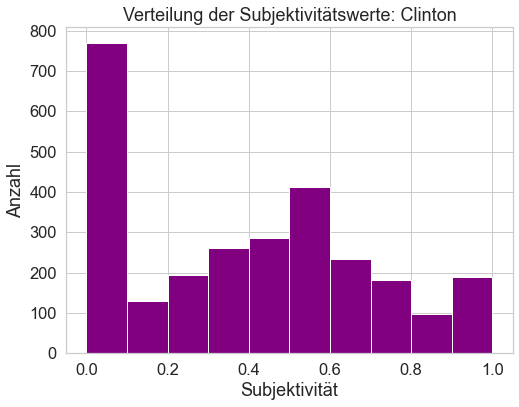

In [17]:
# Visualisierung des Histogramms der Subjektivität der Tweets.
fig, ax = plt.subplots(figsize=(8, 6))
subjectivity_df.hist(bins=[0.0 ,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ax=ax, color="purple")
plt.title("Verteilung der Subjektivitätswerte: Clinton")
plt.xlabel('Subjektivität')
plt.ylabel('Anzahl')
plt.savefig("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_subjectivity_tweets.png")
plt.show()

In [18]:
# Exportieren der Werte der Subjektivität als .csv-Datei.
subjectivity_df.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_subjectivity.csv")

# Laden der .csv-Datei der Subjektivität in eine neue Tabelle.
clinton_subjectivity = Table.read_table("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_subjectivity.csv")
clinton_subjectivity 

Unnamed: 0,Subjectivity,Decapitalized
0,0.2,putins puppet is at it again taking russian help for him ...
1,0.4875,advancing the rights of women and girls is the great unf ...
2,0.508333,small islands contribute the least to climate change but ...
3,0.371429,such a terrific day visiting clintonfdn partners in puer ...
4,0.313333,in the last 24 hours the american president has 1 corrup ...
5,0,today commit to voteforjaimeguttenberg and an end to gun ...
6,0.56,today we remember parkland and the 17 people whose lives ...
7,0.625,for 100 years lwv has empowered voters and defended demo ...
8,0.2,trump is using the powers of the presidency like a tyran ...
9,0,do you realize intimidating judges is the behavior of fa ...


In [19]:
# Laden der Sentiment .csv-Datei in eine neue Tabelle.
clinton_sentiment = Table.read_table("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_sentiment.csv")

# Zusammenführen der Tabellen des Sentiments und der Subjektivität
clinton_sentiment_subjectivity = clinton_sentiment.join("Unnamed: 0", clinton_subjectivity, "Unnamed: 0").drop("Unnamed: 0", "Decapitalized_2").relabeled("Decapitalized","Tweet")

# Exportieren der Werte als .csv-Datei.
clinton_sentiment_subjectivity.to_csv("C:/Users/cati_/Desktop/Sentiment_Data_Try/Clinton_sentiment_subjectivity.csv")
clinton_sentiment_subjectivity

Sentiment,Tweet,Subjectivity
0.4,putins puppet is at it again taking russian help for him ...,0.2
0.5,advancing the rights of women and girls is the great unf ...,0.4875
-0.245833,small islands contribute the least to climate change but ...,0.508333
0.114286,such a terrific day visiting clintonfdn partners in puer ...,0.371429
-0.04,in the last 24 hours the american president has 1 corrup ...,0.313333
0,today commit to voteforjaimeguttenberg and an end to gun ...,0
-0.06,today we remember parkland and the 17 people whose lives ...,0.56
0.225,for 100 years lwv has empowered voters and defended demo ...,0.625
-0.7,trump is using the powers of the presidency like a tyran ...,0.2
0,do you realize intimidating judges is the behavior of fa ...,0


### 4. Ermittlung der Anzahl der Wörter und der Majuskelschreibung

In [20]:
# Funktion zur Aufteilung der Tweets in einzelne Segmente, um die Anzahl ihrer Wörter zu ermitteln.
def word_count(word):
    return len(word.split())
word_count(clinton_sixth.column('Decapitalized').item(0))

# Anwendung der Funktion auf die im Vorfeld bereinigte Spalte bzw. den Text.
tweet_count = clinton_sixth.apply(word_count, 'Decapitalized')

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_upper_table = clinton_sixth.with_column("Word Amount", tweet_count).select("Upper Text", "Decapitalized", "Word Amount")
clinton_upper_table

Upper Text,Decapitalized,Word Amount
[],putins puppet is at it again taking russian help for him ...,24
['DVF'],advancing the rights of women and girls is the great unf ...,44
['CGI'],small islands contribute the least to climate change but ...,41
[],such a terrific day visiting clintonfdn partners in puer ...,44
[],in the last 24 hours the american president has 1 corrup ...,45
[],today commit to voteforjaimeguttenberg and an end to gun ...,14
['AM'],today we remember parkland and the 17 people whose lives ...,36
['LWV'],for 100 years lwv has empowered voters and defended demo ...,38
[],trump is using the powers of the presidency like a tyran ...,32
[],do you realize intimidating judges is the behavior of fa ...,13


In [21]:
# Summe der gesamten Wortzahl des Korpus.
clinton_wordcount_total = sum(tweet_count)
clinton_wordcount_total

64320

In [22]:
# Funktion zur Umwandlung des Python-Formats "Nested Lists" in eine einzelne "Flatten List", zur Ausgabe der Wörter und Anzahl der Majuskelschreibung.
clinton_upper_word = []
for tweet in clinton_upper:
    clinton_upper_word.extend(tweet)

clinton_upper_word

# Summe der gesamten Anzahl der Majuskelschreibung.
clinton_upper_count = len(clinton_upper_word)
clinton_upper_count

746

In [23]:
# Funktion zur Ermittlung der Summe der Majuskelschreibung pro Tweet.
clinton_upper_number = []
for word_amount in clinton_upper:
    clinton_upper_number.append(len(word_amount))
    
clinton_upper_number

# Inkludieren der Variable in die ausgewählte Tabelle durch eine neue Spalte.
clinton_upper_proportion = clinton_upper_table.with_column("Upper Amount", clinton_upper_number)
clinton_upper_proportion

Upper Text,Decapitalized,Word Amount,Upper Amount
[],putins puppet is at it again taking russian help for him ...,24,0
['DVF'],advancing the rights of women and girls is the great unf ...,44,1
['CGI'],small islands contribute the least to climate change but ...,41,1
[],such a terrific day visiting clintonfdn partners in puer ...,44,0
[],in the last 24 hours the american president has 1 corrup ...,45,0
[],today commit to voteforjaimeguttenberg and an end to gun ...,14,0
['AM'],today we remember parkland and the 17 people whose lives ...,36,1
['LWV'],for 100 years lwv has empowered voters and defended demo ...,38,1
[],trump is using the powers of the presidency like a tyran ...,32,0
[],do you realize intimidating judges is the behavior of fa ...,13,0
